In [1]:
# Import necessary libraries
from ultralytics import YOLO
from PIL import Image

In [3]:
model = YOLO("../weights/bestV8.pt")

In [94]:
image_path = '../training images/other/IMG_0553.JPEG'

In [95]:
results = model.predict(image_path, conf=0.9)
results[0].show()


image 1/1 c:\Users\samad\Coding\Tuwaiq\capstone-project-team01\model testing\..\training images\other\IMG_0553.JPEG: 640x640 16 blacks, 32 emptys, 16 whites, 151.0ms
Speed: 8.3ms preprocess, 151.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


In [96]:
# Function to get the board coordinates
def get_board_coordinates(xyxy):
    min_x = xyxy[:, 0].min().item()
    max_x = xyxy[:, 2].max().item()
    min_y = xyxy[:, 1].min().item()
    max_y = xyxy[:, 3].max().item()
    return min_x - 5, min_y - 5, max_x + 5, max_y + 5

In [97]:
xyxy = results[0].boxes.xyxy
min_x ,min_y ,max_x ,max_y = get_board_coordinates(xyxy)
print(f"Crop coordinates: ({min_x}, {min_y}), ({max_x}, {max_y})")

Crop coordinates: (181.83790588378906, 148.9334716796875), (1633.6466064453125, 1506.87353515625)


In [98]:
img = Image.open(image_path)
width, height = img.size
print(width, ', ', height)

1772 ,  1772


In [99]:
lm = min_x
rm = width - max_x
bm = min_y
tm = height - max_y
print(tm, ', ', rm, ', ', bm, ', ', lm)


265.12646484375 ,  138.3533935546875 ,  148.9334716796875 ,  181.83790588378906


In [100]:
new_shape = ((width - (lm + rm)), (height - (tm + bm)))
new_shape

(1451.8087005615234, 1357.9400634765625)

In [101]:
# # Open the image using Pillow
# img = Image.open(image_path)

# # Crop the image
# cropped_img = img.crop((min_x, min_y, max_x, max_y))

# # Save the cropped image
# cropped_img.save('cropped_image.JPEG')
# print("Cropped image saved as 'cropped_image.JPEG'.")

In [102]:
# predict based on cropped
# results = model.predict(cropped_img, conf=0.05)
# results[0].show()

In [103]:
grid_rows = grid_cols = 8

# Create a grid for spaces (reversed order)
def create_grid(grid_rows, grid_cols):
    spaces = []
    for i in range(grid_rows):
        for j in range(grid_cols):
            spaces.append(f"{chr(72 - i)}{j + 1}")  # Start from 'H' (72 in ASCII)
    return spaces
spaces = create_grid(grid_rows, grid_cols)

In [104]:
# Map detections to cells (reversed grid)
def map_detections_to_spaces(boxes, spaces, classes, frame_shape, grid_rows, grid_cols):
    # Initialize all spaces to "initial"
    occupancy = {space: "initial" for space in spaces}
    index = 0
    row_ratio = grid_rows / frame_shape[0]
    col_ratio = grid_cols / frame_shape[1]

    row_size = 1 / row_ratio
    cells = []
    for box in boxes:
        # Calculate the center of the box
        # x_center = (box[0] + box[2]) / 2
        x_center = ((box[0] + box[2]) / 2) + ( 0.25 * row_size) - lm
        y_center = ((box[1] + box[3]) / 2) - bm


        # Calculate row and column indices
        row = int(y_center * row_ratio)
        col = int(x_center * col_ratio)

        # Clamp row and column indices to valid grid bounds
        row = max(0, min(row, grid_rows - 1))  # Ensure 0 <= row < grid_rows
        col = max(0, min(col, grid_cols - 1))  # Ensure 0 <= col < grid_cols

        # Map to a space identifier, reversed for rows
        space = f"{chr(72 - row)}{col + 1}"  # Reverse row index to start from 'H' (72)
        occupancy[space] = classes[index]
        cells.append(f'box{index}: class: {classes[index]}, space: {space}')
        index += 1
        
    return occupancy, cells
    

In [105]:
boxes = results[0].boxes.xyxy.cpu().numpy() if results else []

predicted_classes = results[0].boxes.cls  # `cls` contains the class indices
class_names = model.names  # Assuming the model has a `names` attribute for class labels
predicted_class_names = [class_names[int(cls_idx)] for cls_idx in predicted_classes]

In [106]:
occupancy, cells = map_detections_to_spaces(boxes, spaces, predicted_class_names, new_shape, 8, 8)
occupancy['B8']
for c in cells:
    if 'H' in c:
        print(c)
len(cells)

box11: class: white, space: H5
box31: class: white, space: H2
box42: class: empty, space: H3
box49: class: empty, space: H7
box51: class: empty, space: H1
box53: class: empty, space: H6
box59: class: black, space: H8
box63: class: black, space: H8


64

In [107]:
def map_occupancy_to_board_status(occupancy):
    # Mapping rows and columns to a 2D array
    rows = ['H', 'G', 'F', 'E', 'D', 'C', 'B', 'A']
    columns = ['1', '2', '3', '4', '5', '6', '7', '8']

    new_board_status = []

    for row in rows:
        row_data = []
        for col in columns:
            key = f"{row}{col}"
            cell_value = occupancy[key]
            row_data.append(cell_value)
        new_board_status.append(row_data)
    
    return new_board_status

new_board_status = map_occupancy_to_board_status(occupancy)

# Print the resulting 2D array
for row in new_board_status:
    print(row)

['empty', 'white', 'empty', 'initial', 'white', 'empty', 'empty', 'black']
['white', 'white', 'empty', 'initial', 'empty', 'empty', 'empty', 'black']
['white', 'white', 'white', 'initial', 'empty', 'white', 'empty', 'black']
['white', 'empty', 'initial', 'white', 'black', 'empty', 'empty', 'black']
['empty', 'white', 'initial', 'empty', 'empty', 'black', 'empty', 'empty']
['white', 'empty', 'initial', 'empty', 'black', 'empty', 'empty', 'black']
['empty', 'black', 'initial', 'empty', 'black', 'black', 'empty', 'empty']
['initial', 'initial', 'initial', 'initial', 'initial', 'initial', 'initial', 'initial']


In [113]:
import numpy as np
import cv2
def create_occupancy_map(occupancy, grid_rows, grid_cols, map_shape=(480, 640, 3)):
    occ_map = np.full(map_shape, (25, 25, 75), dtype=np.uint8)

    for i, row in enumerate(range(65, 65 + grid_rows)):
        for j in range(grid_cols):
            space = f"{chr(72 - i)}{j + 1}"  # Reverse row to start from 'H' (72)
            x1 = 10 + j * (map_shape[1] - 20) // grid_cols
            y1 = 10 + i * (map_shape[0] - 20) // grid_rows
            x2 = 10 + (j + 1) * (map_shape[1] - 20) // grid_cols
            y2 = 10 + (i + 1) * (map_shape[0] - 20) // grid_rows

            # Define a mapping of class to color
            class_to_color = {
                "empty": (0, 255, 0),    # Green
                "black": (0, 0, 0),      # Black
                "white": (255, 0, 255),  # White
                "initial": (255, 100, 0) # Yellow
            }
            color = class_to_color.get(occupancy[space], (128, 128, 128))  # Default color

            cv2.rectangle(occ_map, (x1, y1), (x2, y2), color, -1)
            cv2.putText(occ_map, space, (x1 + 5, y1 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return occ_map

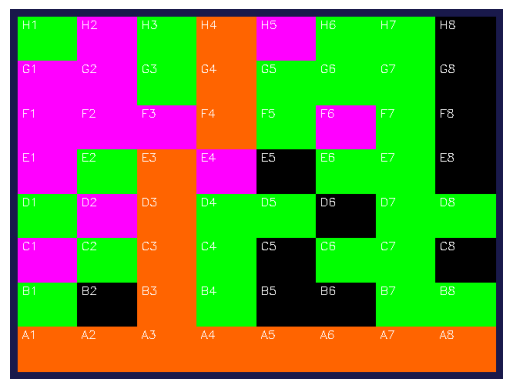

In [120]:
import matplotlib.pyplot as plt
oc_map = create_occupancy_map(occupancy, 8, 8)

plt.imshow(oc_map)
plt.axis('off')
plt.show()
